<a href="https://colab.research.google.com/github/aCStandke/GAN_Models/blob/main/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN
> This is the CycleGAN implementation as detailed by tensorflow Core Tutorials [CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan) to do image segemntation on the cityscape data as detailed by tensorflow datasets [datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan). Additionally, the following sources were copy and pasted (I mean implemented 🤪): 
> 1.   [tf.data.Dataset](https://www.tensorflow.org/tutorials/load_data/images)
> 2.   [encode tensor into jpg image](https://stackoverflow.com/questions/40320271/how-do-we-use-tf-image-encode-jpeg-to-write-out-an-image-in-tensorflow)
> 3.   [downloading folders from Google Colab](https://stackoverflow.com/questions/50453428/how-do-i-download-multiple-files-or-an-entire-folder-from-google-colab)




In [1]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-1h2nmu3a
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-1h2nmu3a
  Created wheel for tensorflow-examples: filename=tensorflow_examples-88287d08f9fe73ef20bbea3cc004440b1c7299f9_-py3-none-any.whl size=299303 sha256=8823ed12642b1c2c9e7b649cc892f75df8317659dbcfa1864595e9c5cd86a960
  Stored in directory: /tmp/pip-ephem-wheel-cache-shrh_mfc/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
# loading tensorflow's pix2pix model 
from tensorflow_examples.models.pix2pix import pix2pix
import pathlib
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numpy import asarray
AUTOTUNE = tf.data.AUTOTUNE

# Loading CityScape Dataset, Formatting into CycleGan Format, and Preprocesing 

In [ ]:
dataset_name = "cityscapes"
_URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"
path_to_zip = tf.keras.utils.get_file(fname=f"{dataset_name}.tar.gz", 
                                      origin = _URL, 
                                      extract = True)
path_to_zip = pathlib.Path(path_to_zip)
PATH = path_to_zip.parent/dataset_name

 28917760/103441232 [=======>......................] - ETA: 2:12

In [ ]:
list(PATH.parent.iterdir())

In [ ]:
!tar -xf '/root/.keras/datasets/cityscapes.tar.gz'

In [ ]:
x = sorted(os.listdir(str(PATH / 'train/')))
y = sorted(os.listdir(str(PATH / 'val')))

In [ ]:
def write_jpeg(data, filepath):
    g = tf.Graph()
    with g.as_default():
        data_t = tf.compat.v1.placeholder(dtype=tf.uint8)
        op = tf.image.encode_jpeg(data_t, format='rgb', quality=100)
        init = tf.compat.v1.initialize_all_variables()

    with tf.compat.v1.Session(graph=g) as sess:
        sess.run(init)
        data_np = sess.run(op, feed_dict={ data_t: data })

    with open(filepath, 'wb') as fd:
        fd.write(data_np)

def process_cityscapes(image_file, output_dir, phase, number):
  save_phase = 'test' if phase == 'val' else 'train'
  savedir = os.path.join(output_dir, save_phase)
    
  image = Image.open(image_file)
  image = asarray(image)
  width = image.shape[1] # get width of image
  width = width//2 # set width to 256
  
  # split the images to create X and Y
  semantic_seg_image = image[:, width:, :]
  driving_image = image[:, :width, :]
  
  savepath = os.path.join(savedir + 'A', f"{number}")
  write_jpeg(semantic_seg_image, savepath)
  savepath = os.path.join(savedir + 'B', f"{number}")
  write_jpeg(driving_image, savepath)

def make_directory(output_dir, phase):
  save_phase = 'test' if phase == 'val' else 'train'
  savedir = os.path.join(output_dir, save_phase)
  os.makedirs(savedir, exist_ok=True)
  os.makedirs(savedir + 'A', exist_ok=True)
  os.makedirs(savedir + 'B', exist_ok=True)
  print("Directory structure prepared at %s" % output_dir)

make_directory('/content/datasets/cityscapes', 'train')
for i in x:
  process_cityscapes(str(PATH/f"train/{i}"), '/content/datasets/cityscapes', 'train', i)
make_directory('/content/datasets/cityscapes', 'val')
for i in y:
  process_cityscapes(str(PATH/f"val/{i}"), '/content/datasets/cityscapes', 'val', i)

In [ ]:
# !zip -r /content/cityscapes.zip /content/datasets/
# from google.colab import files
# files.download("/content/cityscapes.zip")

In [ ]:
train_seg = tf.data.Dataset.list_files("/content/datasets/cityscapes/trainA/*.jpg")
train_photo = tf.data.Dataset.list_files("/content/datasets/cityscapes/trainB/*.jpg")
test_seg = tf.data.Dataset.list_files("/content/datasets/cityscapes/testA/*.jpg")
test_photo = tf.data.Dataset.list_files("/content/datasets/cityscapes/testB/*.jpg")

In [ ]:
print(tf.data.experimental.cardinality(train_seg).numpy())
print(tf.data.experimental.cardinality(train_photo).numpy())
print(tf.data.experimental.cardinality(test_seg).numpy())
print(tf.data.experimental.cardinality(test_photo).numpy())

In [ ]:
TRAIN_BUFFER_SIZE = 3000
TEST_BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)
  # random mirroring
  image = tf.image.random_flip_left_right(image)
  return image


def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return img

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = random_jitter(img)
  img = normalize(img)
  return img

train_seg = train_seg.cache().map(process_path, num_parallel_calls=AUTOTUNE).shuffle(TRAIN_BUFFER_SIZE).batch(BATCH_SIZE)
train_photo = train_photo.cache().map(process_path, num_parallel_calls=AUTOTUNE).shuffle(TRAIN_BUFFER_SIZE).batch(BATCH_SIZE)
test_seg = test_seg.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(TEST_BUFFER_SIZE).batch(BATCH_SIZE)
test_photo = test_photo.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(TEST_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_seg = next(iter(train_seg))
sample_photo = next(iter(train_photo))

In [ ]:
plt.subplot(121)
plt.title('segmentation')
plt.imshow(sample_seg[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Segmentation with random jitter')
plt.imshow(random_jitter(sample_seg[0]) * 0.5 + 0.5)

In [ ]:
plt.subplot(121)
plt.title('photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

# Importing and reusing the Pix2Pix model

Differences amoung Pix2Pix and CycleGAN and the tutorial:
1.   Cyclegan uses instance normalization instead of batch normalization.
2.   The CycleGAN paper uses a modified resnet based generator. This tutorial is using a modified form of the pix2pix unet generator for simplicity.










In [ ]:
OUTPUT_CHANNELS = 3
# generator G: X -> Y
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
# generator F: Y -> X
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
# discriminator X: differentiates between image X and F(Y)
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
# discriminator Y: differnentiates between image Y and G(X)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Testing out the genrators on the sample data

In [ ]:
to_photo = generator_g(sample_seg)
to_seg = generator_f(sample_photo)
plt.figure(figsize=(8, 8))
contrast = 8 

imgs = [sample_seg, to_photo, sample_photo, to_seg]
title = ["Segmentation", "To Photo", "Photo", "To Segmentation"]

for i in range(len(imgs)):
  plt.subplot(2,2, i+1)
  plt.title(title[i])
  if i % 2 ==0:
    plt.imshow(imgs[i][0]*0.5+0.5)
  else:
    plt.imshow(imgs[i][0]*0.5*contrast+0.5)
plt.show()

Testing out the discriminator on the sample data

In [ ]:
plt.figure(figsize=(8, 8))
img = discriminator_y(sample_photo)[0,..., -1]
plt.subplot(121)
plt.title('Is this a real photo?')
plt.imshow(img, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
# where white indicates discriminator thinks it's a photo and Black/gray indicates the discriminator thinks it's not a photo
plt.clim(0, 1)

img = discriminator_x(sample_seg)[0,..., -1]
plt.subplot(122)
plt.title('Is this a real segmentaion?')
plt.imshow(img, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
# where white indicates discriminator thinks it's a segmentaion and Black/gray indicates the discriminator thinks it's not a segmentation
plt.clim(0, 1)



# Loss Functions
*  Basically the same loss functions as Pix2Pix expect for Cycle consistency Loss and Identity Loss
  *  **Cycle consistency Loss**: means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the original sentence  
  *   **Identitly Loss**: As explained by the authors of [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)
    > For painting to photo (and thus also, photo to painting), we find that it is helpful to introduce an additional loss to encourage the mapping to preserve color composition between the input and output. In particular, we adopt the technique of Taigman et al. and regularize the generator to be near an identity mapping when real samples of the target domain are provided as the input to the generator: i.e., L<sub>identity</sub>(G, F) = E<sub>y∼pdata</sub>(y)
||G(y) − y||<sub>1</sub> + E<sub>x∼pdata</sub>(x)||F(x) − x||<sub>1</sub>.Without L<sub>identity</sub>, the generator G and F are free to
change the tint of input images when there is no need to.
For example, when learning the mapping between Monet’s
paintings and Flickr photographs, the generator often maps
paintings of daytime to photographs taken during sunset,
because such a mapping may be equally valid under the adversarial loss and cycle consistency loss.

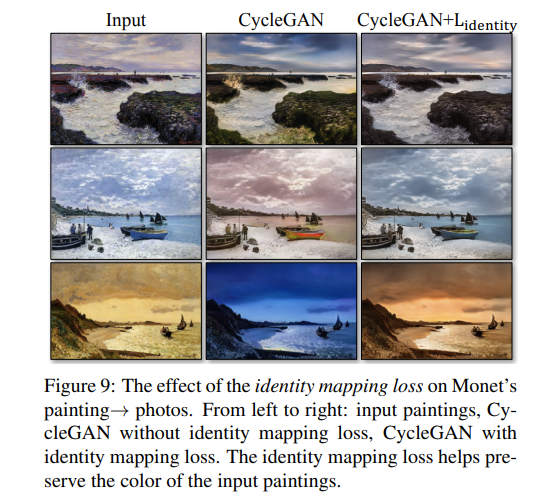









In [ ]:
# parameter used to weight cycle consistency loss
LAMBDA = 10 

In [ ]:
# binary cross entrophy loss
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True) 

In [ ]:
# discriminator loss
def discriminator_loss(real, generated):
  # real loss portion: log(D(Y)) or log(D(X))
  real_loss = loss_obj(tf.ones_like(real), real)
  # generated loss portion: 1-log(D(G(X))) or 1-log(D(F(Y)))
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  # total disc loss
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

In [ ]:
# generator loss
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
# cycle consistency loss
def calc_cycle_loss(real_image, cycled_image):
  cycle_loss = tf.reduce_mean(tf.abs(real_image-cycled_image))
  return LAMBDA * cycle_loss

In [ ]:
# identity loss
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
# initializing the optimizers for the Generators and discriminators
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training

In [ ]:
EPOCHS = 40

In [ ]:
# plotting function for the images
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_photo, train_seg)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1
  clear_output(wait=True)
  # Using a consistent image  so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_photo)
  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
generator_g.save('/content/model/segmentation/')

In [ ]:
for inp in test_photo.take(5):
  generate_images(generator_g, inp)